Latent_Factor_with_biases_with_preproc_and_code_optimization

In [113]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import datetime
import time
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
path_dataset = "data_train.csv"
ratings_data = load_data(path_dataset)
print('Shape of ratings matrix:',ratings_data.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (10000, 1000)


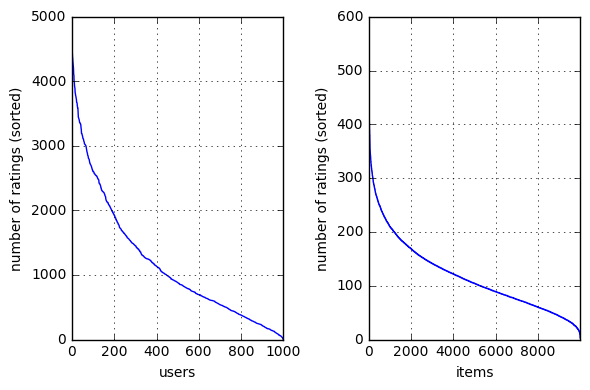

min # of items per user = 8, min # of users per item = 3.


In [115]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings_data)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [128]:
np.random.seed(77)


In [154]:
# Chose submatrix from the 10000x1000 matrix
ratings = scipy.sparse.lil_matrix.todense(ratings_data)
sub_rows = np.random.randint(0, ratings.shape[0], 2000)
sub_cols = np.random.randint(0, ratings.shape[1], 250)
ratings = ratings[sub_rows,:]
ratings = ratings[:,sub_cols]

In [155]:
print(ratings.shape)
print(len(ratings.nonzero()[0]))

(2000, 250)
55557


In [156]:
def remove_empty_rows_and_cols(ratings):

    del_rows = ([])
    for row in range(ratings.shape[0]):
        if len(ratings[row,:].nonzero()[0]) == 0:
            del_rows.append(row)

    ratings = np.delete(ratings,del_rows,axis=0)
    
    del_cols = ([])
    for col in range(ratings.shape[1]):
        if len(ratings[:,col].nonzero()[0]) == 0:
            del_cols.append(col)
            

    ratings = np.delete(ratings,del_cols,axis=1)
    return ratings

In [157]:
def preprocess(ratings):
    
    def find_mean_vectors(ratings):
        
        # calculating the user_mean and item_mean vectors:

        # user_mean vector:

        user_mean = np.zeros((ratings.shape[1],1))

        for user_no in range(ratings.shape[1]):

            a = ratings[:,user_no].sum()
            b = np.shape(ratings[:,user_no].nonzero())[1]
            user_mean[user_no,0] = (a/b)

        # item_mean vector:

        item_mean = np.zeros((ratings.shape[0],1))

        for item_no in range(ratings.shape[0]):

            a = ratings[item_no,:].sum()
            b = np.shape(ratings[item_no,:].nonzero())[1]
            item_mean[item_no,0] = (a/b)
        print('user_mean and item_mean computed!')   
        return user_mean, item_mean

    user_mean, item_mean = find_mean_vectors(ratings)
    
    mask = ratings.copy()
    mask[mask>0] = 1
#     mask = scipy.sparse.lil_matrix.todense(mask)
    
    A = ((user_mean@np.ones((1,ratings.shape[0]))).T)
    B = ((item_mean@np.ones((1,ratings.shape[1]))))
    preproc_layer = ( np.multiply(mask,A)
                     + np.multiply(mask,B) ) / 2
    
#     ratings_dense = scipy.sparse.lil_matrix.todense(ratings)
    ratings_dense = ratings
    ratings_preproc = (ratings_dense - (preproc_layer))
    retrieve_layer = (A + B)/2
    return ratings_preproc, preproc_layer, retrieve_layer

In [158]:
def find_global_mean(ratings):
    global_mean = np.sum(ratings)/len(ratings.nonzero()[0])
    print(global_mean,'global_mu')
    return global_mean

In [159]:
def find_bias_vectors(ratings):
    
    # calculating the user_bias and item_bias vectors:

    global_mean = np.sum(ratings)/len(ratings.nonzero()[0])
    print(global_mean,'global_mu')

    # user_bias vector:
    user_bias = np.zeros((ratings.shape[1],1))

    for user_no in range(ratings.shape[1]):

        a = ratings[:,user_no].sum()
        b = np.shape(ratings[:,user_no].nonzero())[1]
        user_bias[user_no,0] = global_mean - (a/b)

    # item_bias vector:
    item_bias = np.zeros((ratings.shape[0],1))

    for item_no in range(ratings.shape[0]):

        a = ratings[item_no,:].sum()
        b = np.shape(ratings[item_no,:].nonzero())[1]
        item_bias[item_no,0] = global_mean - (a/b)
    
    print('user_bias and item_bias computed!')   
    return global_mean, user_bias, item_bias

In [160]:
ratings = remove_empty_rows_and_cols(ratings)
ratings_preproc, preproc_layer, retrieve_layer = preprocess(ratings)
global_mean, user_bias_stored, item_bias_stored = find_bias_vectors(ratings_preproc)

user_mean and item_mean computed!
6.37907602441e-18 global_mu
user_bias and item_bias computed!


In [161]:
def SGD_train(gamma,num_features,lambda_,num_epochs,ratings,change_step):
    
    
    global_mean = find_global_mean(ratings)
    # define parameters
    gamma =  gamma   #0.00008 for no lambdas and w/0 preproc, 0.003 for the cluster code
    num_features = num_features   # K in the lecture notes
    split_ratio = 0.8   # ratio between size of training and test set
    lambda_ = lambda_
    [lambda_user, lambda_item, lambda_user_bias, lambda_item_bias] = [lambda_, lambda_, lambda_, lambda_]
    num_epochs = num_epochs     # number of full passes through the train set


    test_mode = True
    if split_ratio == 1.0:
        test_mode = False

    def nonzero_indices(matrix):
        nz_row, nz_col = matrix.nonzero()
        return list(zip(nz_row, nz_col))

    nonzero_indices = nonzero_indices(ratings)
    split_point = int(np.floor(len(nonzero_indices) * split_ratio))
    train_nonzero_indices = nonzero_indices[:split_point]
    test_nonzero_indices = nonzero_indices[split_point:]

    train_set = np.zeros(ratings.shape)
    test_set = np.zeros(ratings.shape)

    for i, j in train_nonzero_indices:
        train_set[i, j] = ratings[i, j]

    for i, j in test_nonzero_indices:
        test_set[i, j] = ratings[i, j]

    # find the non-zero ratings indices 
    nz_row, nz_col = train_set.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test_set.nonzero()
    nz_test = list(zip(nz_row,nz_col))


    # init matrix
    item_features = np.zeros((train_set.shape[0],num_features))
    user_features = np.zeros((train_set.shape[1],num_features))

    user_bias = np.zeros((train_set.shape[1]))
    item_bias = np.zeros((train_set.shape[0]))

    real_train_label = np.zeros(len(nz_train))
    prediction_train = np.zeros(len(nz_train))
    rmse_train = np.zeros(num_epochs)


    # Printing training rmse before any update loop

    mat_pred = ( global_mean*np.ones((train_set.shape)) +
                (user_bias.reshape((train_set.shape[1],1)).dot(np.ones((1,train_set.shape[0])))).T +
                (item_bias.reshape((train_set.shape[0],1)).dot(np.ones((1,train_set.shape[1])))) +
                np.dot(item_features,user_features.T) )

    mat_pred_for_mse = (mat_pred + retrieve_layer)

    for i in range(len(nz_train)):
        real_train_label[i] = train_set[nz_train[i][0],nz_train[i][1]] + retrieve_layer[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred_for_mse[nz_train[i][0],nz_train[i][1]]

    rmse = calculate_mse(real_train_label, prediction_train)
#     print('Train rmse with initialization: ',rmse)   
    print('gamma = ',gamma)

    if test_mode == True:

        real_test_label  = np.zeros(len(nz_test))
        prediction_test = np.zeros(len(nz_test))
        rmse_test  = np.zeros(num_epochs)

        # Printing test rmse before any update loop

        for i in range(len(nz_test)):
            real_test_label[i] = test_set[nz_test[i][0],nz_test[i][1]] + retrieve_layer[nz_test[i][0],nz_test[i][1]]
            prediction_test[i] = mat_pred_for_mse[nz_test[i][0],nz_test[i][1]]

        rmse = calculate_mse(real_test_label, prediction_test)
#         print('Test rmse with initialization: ',rmse)  


    for it in range(num_epochs): 
        if change_step == True:
            if it>11:
                gamma = 0.00002

#         print('Iteration No',it+1)
        
        # decrease step size
        # gamma /= 1.2

        begin = datetime.datetime.now()
        count = 0
        for d,n in nz_train:
#             count += 1
#             if count%10000 == 0:
#                 print(count)
            difference = train_set[d,n] - mat_pred[d,n]

            # Updating the W
            gradient1 = -1* (difference) * user_features[n,:]
            item_features[d,:] = item_features[d,:]*(1 - gamma*lambda_item) - gamma * gradient1


            # Updating the Z
            gradient2 = -1* (difference) * item_features[d,:]
            user_features[n,:] = user_features[n,:]*(1 - gamma*lambda_user) - gamma * gradient2

            # Updating the user_bias vector
            gradient3 = -1* (difference) 
            user_bias[n] = user_bias[n]*(1 - gamma*lambda_user_bias) - gamma * gradient3

            # Updating the item_bias vector
            gradient4 = -1* (difference)
            item_bias[d] = item_bias[d]*(1 - gamma*lambda_item_bias) - gamma * gradient4


            mat_pred[d,:] = (np.dot(user_features,item_features[d,:])
                             + user_bias
                             + item_bias[d]*np.ones((ratings.shape[1])) 
                             + global_mean*np.ones((ratings.shape[1])))

            mat_pred[:,n] = (np.dot(item_features,user_features[n,:])
                             + item_bias
                             + user_bias[n]*np.ones((ratings.shape[0]))
                             + global_mean*np.ones((ratings.shape[0])))

        mat_pred_for_mse = (mat_pred + retrieve_layer)

        #Calculating training rmse
        for i in range(len(nz_train)):
            real_train_label[i] = train_set[nz_train[i][0],nz_train[i][1]] + retrieve_layer[nz_train[i][0],nz_train[i][1]]
            prediction_train[i] = mat_pred_for_mse[nz_train[i][0],nz_train[i][1]]

        rmse = calculate_mse(real_train_label, prediction_train) 
        rmse_train[it] = rmse

        if test_mode == True:

            for i in range(len(nz_test)):
                real_test_label[i] = test_set[nz_test[i][0],nz_test[i][1]] + retrieve_layer[nz_test[i][0],nz_test[i][1]]
                prediction_test[i] = mat_pred_for_mse[nz_test[i][0],nz_test[i][1]]

            rmse_t = calculate_mse(real_test_label, prediction_test)
            rmse_test[it] = rmse_t

#         print("iter: {}, RMSE on training set: {}.".format(it+1, rmse))
#         if test_mode == True:
#             print("iter: {}, RMSE on testing set: {}.".format(it+1, rmse_t))
        end = datetime.datetime.now()
        execution_time = (end - begin).total_seconds()

#         print('Iteration runtime: ',execution_time)
#         gamma = gamma/2
    
#     plt.plot(np.arange(num_epochs),rmse_train,np.arange(num_epochs),rmse_test)
    
    return mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train

Trying gamma (stepsize) =  0.0005
4.0772187477e-18 global_mu
gamma =  0.0005


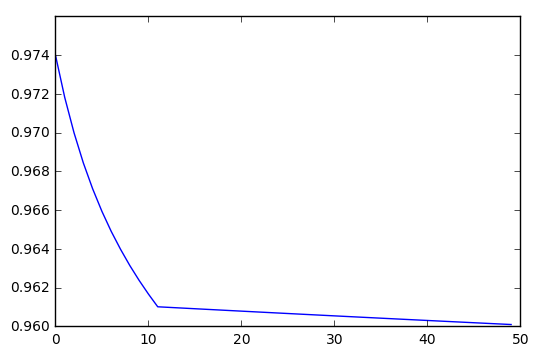

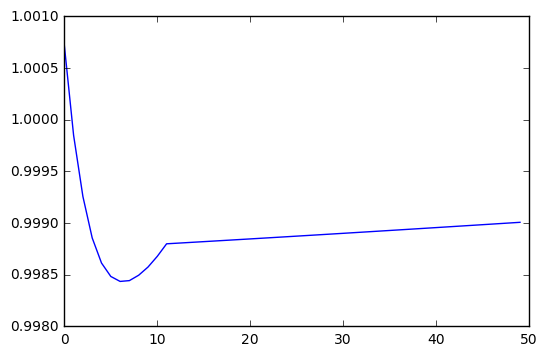

In [137]:
gamma =   0.0005   #0.00008 for no lambdas and w/0 preproc, 0.003 for the cluster code
num_features = 50#20   # K in the lecture notes
lambda_ = 0 #5 #0.7
num_epochs = 50

print('Trying gamma (stepsize) = ',gamma)
[mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
    SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc))
plt.plot(np.arange(num_epochs),rmse_train)
plt.show()
plt.plot(np.arange(num_epochs),rmse_test)
plt.show()

Trying gamma (stepsize) =  0.02
4.0772187477e-18 global_mu
gamma =  0.02
Trying gamma (stepsize) =  0.002
4.0772187477e-18 global_mu
gamma =  0.002
Trying gamma (stepsize) =  0.0002
4.0772187477e-18 global_mu
gamma =  0.0002
Trying gamma (stepsize) =  2e-05
4.0772187477e-18 global_mu
gamma =  2e-05
Trying gamma (stepsize) =  2e-06
4.0772187477e-18 global_mu
gamma =  2e-06
Trying gamma (stepsize) =  2e-07
4.0772187477e-18 global_mu
gamma =  2e-07


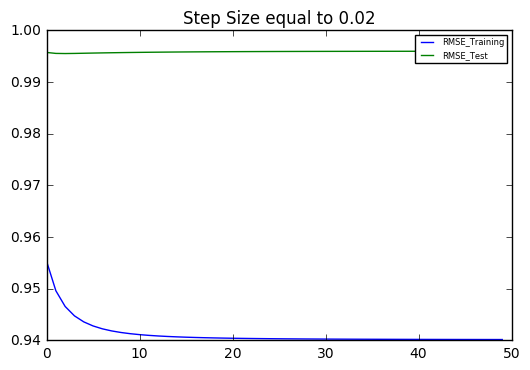

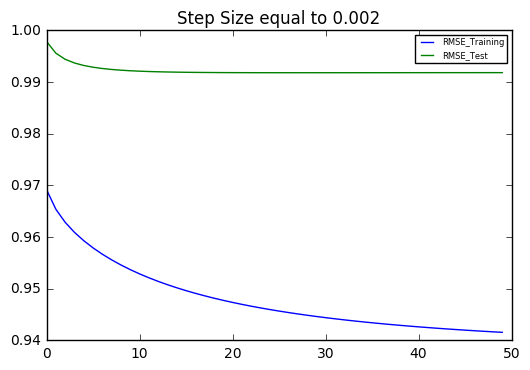

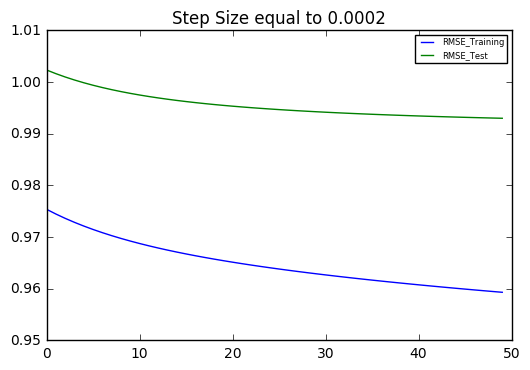

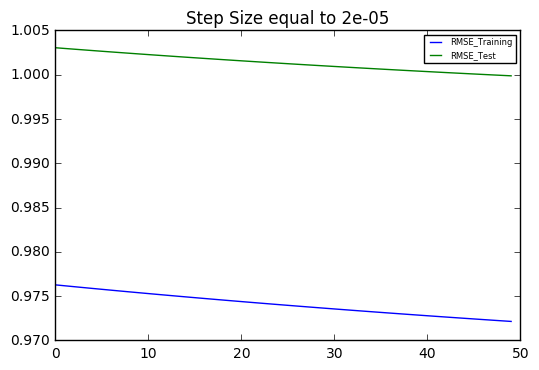

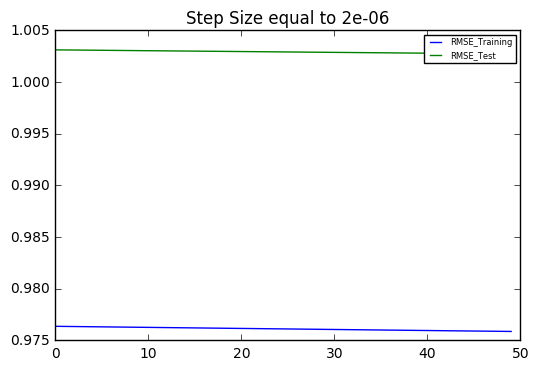

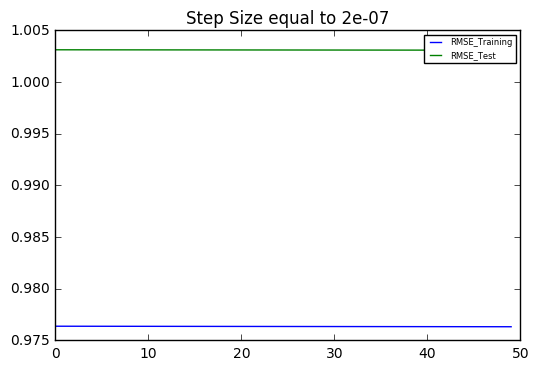

In [146]:
num_features = 20   # K in the lecture notes
lambda_ = 0
num_epochs = 50
best_gamma = 0.02
rmse_last = np.inf

gamma_list = [0.02,0.002,0.0002,0.00002,0.000002,0.0000002]
all_mat_pred = ([])
all_rmse_test = ([])
all_rmse_train = ([])

for ind,gamma in enumerate(gamma_list):
    print('Trying gamma (stepsize) = ',gamma)
    [mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
        SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc))
    
    all_mat_pred.append(mat_pred + retrieve_layer)
    all_rmse_test.append(rmse_test)
    all_rmse_train.append(rmse_train)
    
    if rmse_last > rmse_test[-1]:
        best_gamma = gamma
        best_ind = ind
        rmse_last = rmse_test[-1]

for ind in range(len(gamma_list)):
    rmse_train = all_rmse_train[ind]
    rmse_test = all_rmse_test[ind]
    plt.plot(np.arange(num_epochs),rmse_train,label='RMSE_Training')
    plt.plot(np.arange(num_epochs),rmse_test,label ='RMSE_Test')
    step_size = gamma_list[ind]
    a = 'Step Size equal to ' + str(step_size)
    plt.title(a)
    plt.legend(loc='upper right',fontsize = 6)
    plt.show()
    plt.close()
    
# print('Best value obtained for the hyperparameter step size is - ',best_gamma)

Factors: 20
Regularization: 0
6.37907602441e-18 global_mu
gamma =  0.0005


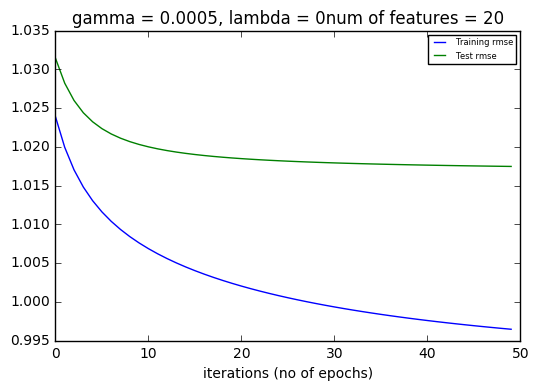

New optimal parameters: num_features =  20 regularization =  0
Factors: 50
Regularization: 0
6.37907602441e-18 global_mu
gamma =  0.0005


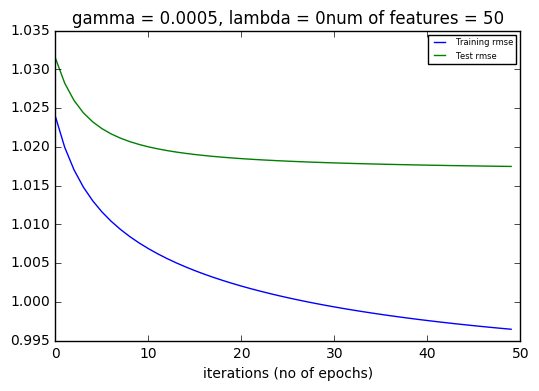

Factors: 80
Regularization: 0
6.37907602441e-18 global_mu
gamma =  0.0005


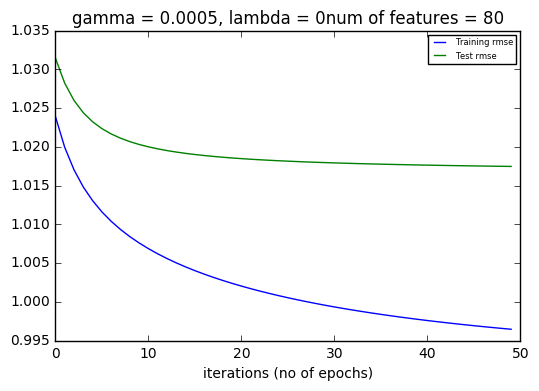

In [162]:
latent_factors = [20, 50, 80]
regularizations = [0]
# regularizations = [0, 0.001, 0.01, 0.1, 1.0]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
gamma = 0.0005
change_step = False

for fact in latent_factors:
    print('Factors: {}'.format(fact) )
    for reg in regularizations:
        print('Regularization: {}'.format(reg) )
        
        num_features = fact
        lambda_ = reg
        
        num_epochs = 50
        [mat_pred, retrieve_layer, user_bias, item_bias, user_features, item_features, rmse_test, rmse_train] = (
            SGD_train(gamma,num_features,lambda_,num_epochs,ratings_preproc,change_step))
        
        plt.plot(np.arange(num_epochs),rmse_train,label= 'Training rmse')
        plt.plot(np.arange(num_epochs),rmse_test,label= 'Test rmse')
        
        
        rmse_old = rmse_test
        b = 'gamma = 0.0005, lambda = ' + str(reg) + 'num of features = ' + str(fact)
        plt.title(b)
        plt.legend(loc='upper right',fontsize = 6)
        plt.xlabel('iterations (no of epochs)')
        plt.show()
        plt.close()
        
        if rmse_test[-1] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['train_mse'] = rmse_train[-1]
            best_params['test_mse'] = rmse_test[-1]
            print('New optimal parameters: num_features = ',fact,'regularization = ',reg)

In [ ]:
plt.subplot(3,2,5)
plt.plot(losses,'-b',label= 'Cross entropy loss: $l(f(X),y)$')
plt.legend(loc='upper right',fontsize = 20)
plt.xlabel('iterations (no of epochs)')
plt.grid()
# plt.title('With duals: beta1 = beta2 = gamma1 = 1')


In [ ]:
def create_csv_submission(prediction, submission_file_path = "submission.csv"):
    """
        Creates an output file in csv format for submission to kaggle.

        Arguments:
            prediction: matrix W * Z^T
            submission_file_path: string name of .csv output file to be created
    """

    dataset_file_path = "sampleSubmission.csv" # file path to the dataset of the entries to be predicted
    sample_ratings = load_data(dataset_file_path)
    
    # find the non-zero ratings indices 
    nz_row_sr, nz_col_sr = sample_ratings.nonzero()
    nz_sr = list(zip(nz_row_sr, nz_col_sr))
    
    def trim_values(x):
        if x < 1:
            return 1
        if x > 5:
            return 5
        return x
    
    submission_file_path = time.strftime("%Y%m%d_%H%M%S") + " " + submission_file_path
    with open(submission_file_path, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for i, j in nz_sr:
            writer.writerow({'Id' : 'r' + str(i + 1) + '_' + 'c' + str(j + 1),
                             'Prediction' : str(trim_values(prediction[i, j]))})

In [ ]:
mat_pred = ( global_mean*np.ones((10000,1000)) +
           (user_bias.reshape((1000,1)).dot(np.ones((1,10000)))).T +
           (item_bias.reshape((10000,1)).dot(np.ones((1,1000)))) +
           np.dot(item_features,user_features.T) )

mat_pred_for_mse = (mat_pred + retrieve_layer)
prediction = mat_pred_for_mse
create_csv_submission(prediction)

In [ ]:
def initialize_matrices_random(train, num_features):
    """
        Initialize randomly matrices W and Z of matrix factorization.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    item_features = np.random.random((train.shape[0], num_features)) # W matrix initialization
    user_features = np.random.random((train.shape[1], num_features)) # Z matrix initialization
    
    return item_features, user_features

In [ ]:
def initialize_matrices_global_mean(train, num_features):
    """
        Initialize matrices W and Z of matrix factorization such that W*Z^T contains global
        mean at all positions. Therefore all elements of W and Z equal to 
        square root of global_mean/num_features

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
            
    """
    global_mean = np.sum(train)/len(train.nonzero()[0])

    # W matrix initialization
    item_features = np.sqrt(global_mean/num_features) * np.ones((train.shape[0], num_features)) 
    # Z matrix initialization
    user_features = np.sqrt(global_mean/num_features) * np.ones((train.shape[1], num_features))
    
    return item_features, user_features

In [ ]:
def initialize_matrices_SVD(train, num_features):
    """
        Initialize matrices W and Z of matrix factorization using SVD decomposition of original matrix X.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    U, s, V = np.linalg.svd(train, full_matrices=False)
    
    S = np.diag(s)

    U_1 = U[:, 0:num_features]
    S_1 = S[0:num_features, 0:num_features]
    V_1 = V[0:num_features, :]
    
    item_features = U_1 # W matrix initialization
    user_features = (S_1.dot(V_1)).T # Z matrix initialization
    
    return item_features, user_features